In [ ]:
!pip install catboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 76.6 MB 69 kB/s 


In [ ]:
import numpy as np
import pandas as pd
pd.set_option('max_columns', 17)
pd.set_option('max_rows', 90)
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')

from sklearn.neighbors import KNeighborsRegressor
import scipy.stats
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor
from sklearn.model_selection import KFold, cross_val_score
from catboost import CatBoostRegressor
from sklearn.linear_model import Ridge
from lightgbm import LGBMRegressor
from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBRegressor
import xgboost as xgb
from sklearn import linear_model

In [ ]:
train0 = pd.read_csv('train.csv')
test0 = pd.read_csv('test.csv')


In [ ]:
train0.info()

In [ ]:
train0.head(18)

**Combine Train and Test Sets**

In [ ]:
target = train0['SalePrice']
test_ids = test0['Id']

train1 = train0.drop(['Id', 'SalePrice'], axis=1)
test1 = test0.drop('Id', axis=1)

data1 = pd.concat([train1, test1], axis=0).reset_index(drop=True)
data1

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,...,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,...,NaN,NaN,NaN,0,2,2008,WD,Normal
1,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,...,NaN,NaN,NaN,0,5,2007,WD,Normal
2,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,...,NaN,NaN,NaN,0,9,2008,WD,Normal
3,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,...,NaN,NaN,NaN,0,2,2006,WD,Abnorml
4,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,...,NaN,NaN,NaN,0,12,2008,WD,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2914,160,RM,21.0,1936,Pave,NaN,Reg,Lvl,...,NaN,NaN,NaN,0,6,2006,WD,Normal
2915,160,RM,21.0,1894,Pave,NaN,Reg,Lvl,...,NaN,NaN,NaN,0,4,2006,WD,Abnorml
2916,20,RL,160.0,20000,Pave,NaN,Reg,Lvl,...,NaN,NaN,NaN,0,9,2006,WD,Abnorml
2917,85,RL,62.0,10441,Pave,NaN,Reg,Lvl,...,NaN,MnPrv,Shed,700,7,2006,WD,Normal


**Cleaning**

In [ ]:
data2 = data1.copy()

**Ensure Proper Data Types**

In [ ]:
data2['MSSubClass'] = data2['MSSubClass'].astype(str)

**Fill Categorical Missing Values**

In [ ]:
# Impute using a constant value
for column in [
    'Alley',
    'BsmtQual',
    'BsmtCond',
    'BsmtExposure',
    'BsmtFinType1',
    'BsmtFinType2',
    'FireplaceQu',
    'GarageType',
    'GarageFinish',
    'GarageQual',
    'GarageCond',
    'PoolQC',
    'Fence',
    'MiscFeature'
]:
    data2[column] = data2[column].fillna("None")


In [ ]:
# Impute using the column mode
for column in [
    'MSZoning',
    'Utilities',
    'Exterior1st',
    'Exterior2nd',
    'MasVnrType',
    'Electrical',
    'KitchenQual',
    'Functional',
    'SaleType'
]:
    data2[column] = data2[column].fillna(data2[column].mode()[0])

In [ ]:
data3 = data2.copy()

**Numeric Missing Values**

In [ ]:
def knn_impute(df, na_target):
    df = df.copy()
    
    numeric_df = df.select_dtypes(np.number)
    non_na_columns = numeric_df.loc[: ,numeric_df.isna().sum() == 0].columns
    
    y_train = numeric_df.loc[numeric_df[na_target].isna() == False, na_target]
    X_train = numeric_df.loc[numeric_df[na_target].isna() == False, non_na_columns]
    X_test = numeric_df.loc[numeric_df[na_target].isna() == True, non_na_columns]
    
    knn = KNeighborsRegressor()
    knn.fit(X_train, y_train)
    
    y_pred = knn.predict(X_test)
    
    df.loc[df[na_target].isna() == True, na_target] = y_pred
    
    return df

In [ ]:
for column in [
    'LotFrontage',
    'MasVnrArea',
    'BsmtFinSF1',
    'BsmtFinSF2',
    'BsmtUnfSF',
    'TotalBsmtSF',
    'BsmtFullBath',
    'BsmtHalfBath',
    'GarageYrBlt',
    'GarageCars',
    'GarageArea'
]:
    data3 = knn_impute(data3, column)

In [ ]:
data4 = data3.copy()

In [ ]:
import plotly.express as px

In [ ]:
fig=px.scatter(x=train0['GrLivArea'],y=train0['SalePrice'],trendline='ols',width=1000, height=600)
fig.show()

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


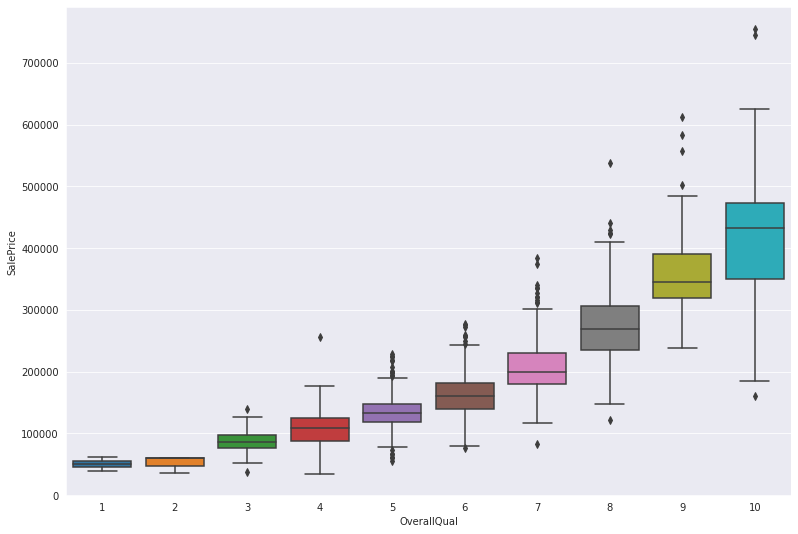

In [ ]:
fig, ax = plt.subplots(figsize=(13,9))
ax = sns.boxplot(x="OverallQual", y="SalePrice", data=train0)

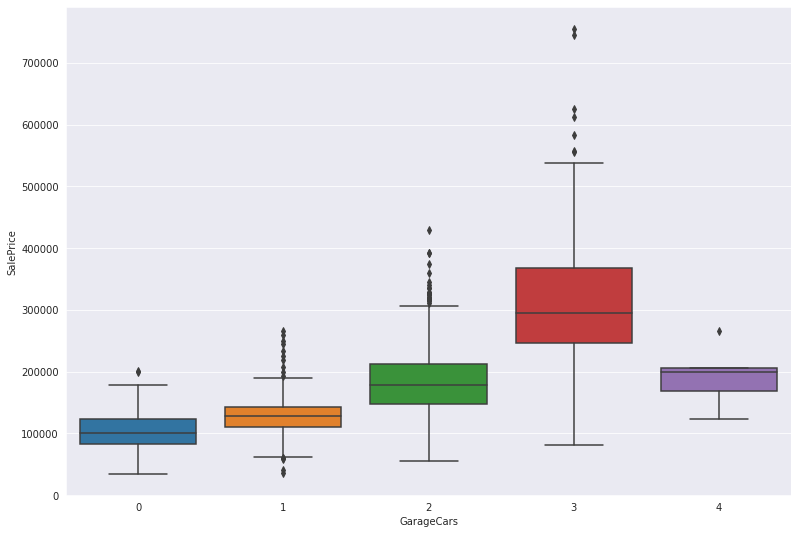

In [ ]:
fig, ax = plt.subplots(figsize=(13,9))
ax = sns.boxplot(x="GarageCars", y="SalePrice", data=train0)

**Feature Engineering**

In [ ]:
data4["SqFtPerRoom"] = data4["GrLivArea"] / (data4["TotRmsAbvGrd"] + data4["FullBath"] + data4["HalfBath"] + data4["KitchenAbvGr"])

data4['HomeQuality'] = data4['OverallQual'] + data4['OverallCond']

data4['Total_Bathrooms'] = (data4['FullBath'] + (0.5 * data4['HalfBath']) +
                               data4['BsmtFullBath'] + (0.5 * data4['BsmtHalfBath']))

data4["CombinedSF"] = data4["1stFlrSF"] + data4["2ndFlrSF"]

In [ ]:
data5 = data4.copy()

**Feature Transformations**

**Target Transformation**

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



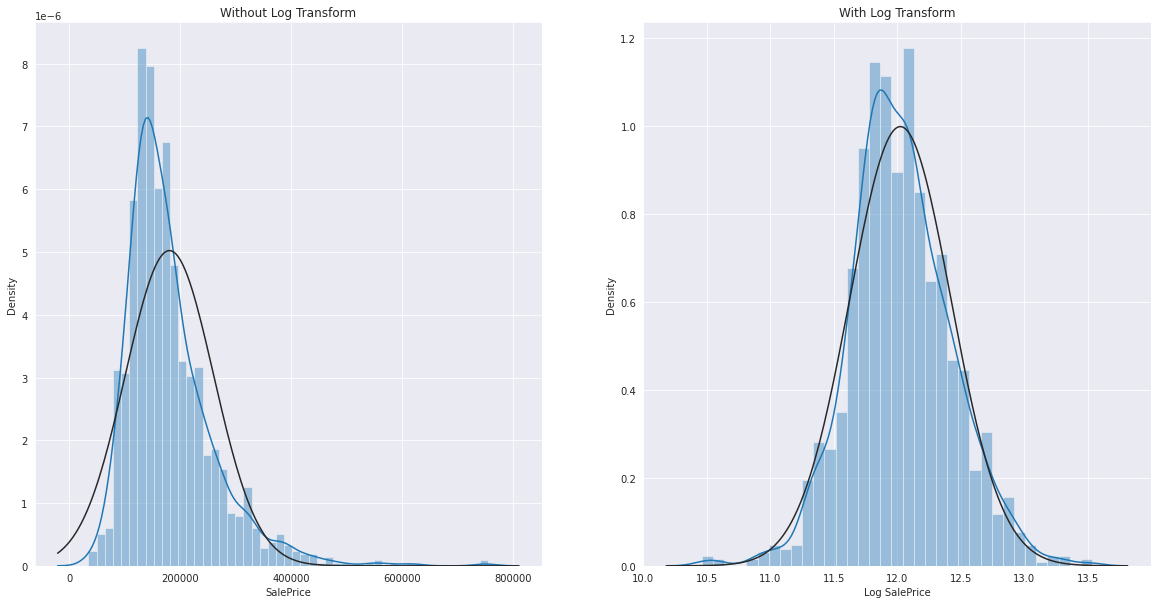

In [ ]:
plt.figure(figsize=(20, 10))

plt.subplot(1, 2, 1)
sns.distplot(target, kde=True, fit=scipy.stats.norm)
plt.title("Without Log Transform")

plt.subplot(1, 2, 2)
sns.distplot(np.log(target), kde=True, fit=scipy.stats.norm)
plt.xlabel("Log SalePrice")
plt.title("With Log Transform")

plt.show()

In [ ]:
log_target = np.log(target)

#StatesModel here


**Log Transform for Skewed Features**

In [ ]:
skew_df = pd.DataFrame(data5.select_dtypes(np.number).columns, columns=['Feature'])
skew_df['Skew'] = skew_df['Feature'].apply(lambda feature: scipy.stats.skew(data5[feature]))
skew_df['Absolute Skew'] = skew_df['Skew'].apply(abs)
skew_df['Skewed'] = skew_df['Absolute Skew'].apply(lambda x: True if x >= 0.5 else False)
skew_df.drop(["Skew"],axis=1)

,Feature,Absolute Skew,Skewed
0,LotFrontage,1.340751,True
1,LotArea,12.822431,True
2,OverallQual,0.197110,False
3,OverallCond,0.570312,True
4,YearBuilt,0.599806,True
5,YearRemodAdd,0.451020,False
6,MasVnrArea,2.603682,True
7,BsmtFinSF1,1.425516,True
8,BsmtFinSF2,4.146111,True
9,BsmtUnfSF,0.919322,True


In [ ]:
for column in skew_df.query("Skewed == True")['Feature'].values:
    data5[column] = np.log1p(data5[column])

In [ ]:
#Cosine Transform for Cyclical Features
data4['MoSold'] = (-np.cos(0.5236 * data5['MoSold']))

In [ ]:
data6 = data5.copy()

**Encode Categoricals**

In [ ]:
data6 = pd.get_dummies(data6)

In [ ]:
data7 = data6.copy()

**Scaling**

In [ ]:
scaler = StandardScaler()
scaler.fit(data7)

data7 = pd.DataFrame(scaler.transform(data7), index=data7.index, columns=data7.columns)

In [ ]:
data7

,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,-0.064176,-0.103719,0.646183,-0.435439,1.040634,0.896833,1.210174,0.783229,...,-0.049029,0.394439,-0.263861,-0.064249,-0.09105,-0.126535,0.463937,-0.302693
1,0.536077,0.146544,-0.063185,1.906370,0.161526,-0.395604,-0.804554,0.892444,...,-0.049029,0.394439,-0.263861,-0.064249,-0.09105,-0.126535,0.463937,-0.302693
2,0.066112,0.457629,0.646183,-0.435439,0.975922,0.848965,1.137926,0.658154,...,-0.049029,0.394439,-0.263861,-0.064249,-0.09105,-0.126535,0.463937,-0.302693
3,-0.295084,0.136301,0.646183,-0.435439,-1.869638,-0.682812,-0.804554,0.386923,...,-0.049029,0.394439,3.789876,-0.064249,-0.09105,-0.126535,-2.155466,-0.302693
4,0.677357,0.922662,1.355551,-0.435439,0.943542,0.753229,1.430432,0.758108,...,-0.049029,0.394439,-0.263861,-0.064249,-0.09105,-0.126535,0.463937,-0.302693
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2914,-3.284214,-2.993401,-1.481920,1.226101,-0.035461,-0.682812,-0.804554,-1.418196,...,-0.049029,0.394439,-0.263861,-0.064249,-0.09105,-0.126535,0.463937,-0.302693
2915,-3.284214,-3.036401,-1.481920,-0.435439,-0.035461,-0.682812,-0.804554,0.438424,...,-0.049029,0.394439,3.789876,-0.064249,-0.09105,-0.126535,-2.155466,-0.302693
2916,2.549545,1.586172,-0.772552,1.226101,-0.365110,0.561757,-0.804554,0.967658,...,-0.049029,0.394439,3.789876,-0.064249,-0.09105,-0.126535,-2.155466,-0.302693
2917,-0.200527,0.311255,-0.772552,-0.435439,0.683917,0.370284,-0.804554,0.535612,...,-0.049029,0.394439,-0.263861,-0.064249,-0.09105,-0.126535,0.463937,-0.302693


In [ ]:
data8 = data7.copy()

**Split Data**

In [ ]:
train_final = data8.loc[:train0.index.max(), :].copy()
test_final = data8.loc[train0.index.max() + 1:, :].reset_index(drop=True).copy()

In [ ]:
train_final

,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,-0.064176,-0.103719,0.646183,-0.435439,1.040634,0.896833,1.210174,0.783229,...,-0.049029,0.394439,-0.263861,-0.064249,-0.09105,-0.126535,0.463937,-0.302693
1,0.536077,0.146544,-0.063185,1.906370,0.161526,-0.395604,-0.804554,0.892444,...,-0.049029,0.394439,-0.263861,-0.064249,-0.09105,-0.126535,0.463937,-0.302693
2,0.066112,0.457629,0.646183,-0.435439,0.975922,0.848965,1.137926,0.658154,...,-0.049029,0.394439,-0.263861,-0.064249,-0.09105,-0.126535,0.463937,-0.302693
3,-0.295084,0.136301,0.646183,-0.435439,-1.869638,-0.682812,-0.804554,0.386923,...,-0.049029,0.394439,3.789876,-0.064249,-0.09105,-0.126535,-2.155466,-0.302693
4,0.677357,0.922662,1.355551,-0.435439,0.943542,0.753229,1.430432,0.758108,...,-0.049029,0.394439,-0.263861,-0.064249,-0.09105,-0.126535,0.463937,-0.302693
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,-0.200527,-0.231508,-0.063185,-0.435439,0.911146,0.753229,-0.804554,-1.418196,...,-0.049029,0.394439,-0.263861,-0.064249,-0.09105,-0.126535,0.463937,-0.302693
1456,0.711638,0.767440,-0.063185,0.454875,0.227056,0.178812,1.021136,0.820898,...,-0.049029,0.394439,-0.263861,-0.064249,-0.09105,-0.126535,0.463937,-0.302693
1457,-0.020100,0.029092,0.646183,2.514892,-0.996100,1.040437,-0.804554,0.467619,...,-0.049029,0.394439,-0.263861,-0.064249,-0.09105,-0.126535,0.463937,-0.302693
1458,0.066112,0.170303,-0.772552,0.454875,-0.696444,0.561757,-0.804554,-0.105594,...,-0.049029,0.394439,-0.263861,-0.064249,-0.09105,-0.126535,0.463937,-0.302693


In [ ]:
log_target

0       12.247694
1       12.109011
2       12.317167
3       11.849398
4       12.429216
          ...    
1455    12.072541
1456    12.254863
1457    12.493130
1458    11.864462
1459    11.901583
Name: SalePrice, Length: 1460, dtype: float64

# **Model Selection**

**Train split for testing**

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(train_final, log_target, test_size = 0.25, random_state = 123)

In [ ]:
#The origial value of y_train and y_test before log transformation
y_test_o = np.expm1(y_test)
y_test_o
y_train_o = np.expm1(y_train)

Evaluation function

In [ ]:
from sklearn.metrics import mean_squared_error

**Linear Regression**

In [ ]:
#fit the model and predict
from sklearn.linear_model import LinearRegression
LR = LinearRegression()
LR.fit(X_train,y_train)
LR_pred = LR.predict(X_test)

In [ ]:
rmse_log = round(np.sqrt(mean_squared_error(y_test, LR_pred)),4)
rmse_log

25605325163.133

In [ ]:
#Check the training error
LR_train_pred = LR.predict(X_train)
rmse_log_train = round(np.sqrt(mean_squared_error(y_train, LR_train_pred)),4)
rmse_log_train

0.0883

In [ ]:
columns = ['Model','Test RMSE(log)','Train RMSE(log)','Test RMSE']
LR_list = ["Linear Regression", rmse_log, rmse_log_train, "None"]
LR_list

['Linear Regression', 25605325163.133, 0.0883, 'None']

**Ridge Regression**

In [ ]:
RR = Ridge(alpha=5.0)
RR.fit(X_train,y_train)
RR_pred = RR.predict(X_test)

In [ ]:
RR_pred = RR.predict(X_test)
rmse_RR = round(np.sqrt(mean_squared_error(y_test, RR_pred)),4)
rmse_RR

0.1267

In [ ]:
#training error
RR_train_pred = RR.predict(X_train)
rmse_train_RR = round(np.sqrt(mean_squared_error(y_train, RR_train_pred)),4)
rmse_train_RR

0.0885

In [ ]:
#Transform the prediction of the log price to original unit and calculate the rmse
RR_pred_o = np.expm1(RR_pred)
rmse_o_RR = round(np.sqrt(mean_squared_error(y_test_o, RR_pred_o)),1)
rmse_o_RR

24489.2

In [ ]:
RR_list = ["Ridge Regression", rmse_RR, rmse_train_RR, rmse_o_RR]
RR_list

['Ridge Regression', 0.1267, 0.0885, 24489.2]

**Lasso Regression**

In [ ]:
LA_R = linear_model.Lasso(alpha=0.004)
LA_R.fit(X_train, y_train)
LA_R_pred = LA_R.predict(X_test)
rmse_LA = np.sqrt(mean_squared_error(y_test, LA_R_pred))
rmse_LA

0.11366261253967751

In [ ]:
#training error
LA_train_pred = LA_R.predict(X_train)
rmse_train_LA = round(np.sqrt(mean_squared_error(y_train, LA_train_pred)),4)
rmse_train_LA

0.1005

In [ ]:
#Transform the prediction of the log price to original unit and calculate the rmse
LA_R_o = np.expm1(LA_R_pred)
rmse_o_LA = round(np.sqrt(mean_squared_error(y_test_o, LA_R_o)),1)
rmse_o_LA

23018.1

In [ ]:
LA_list = ["Lasso Regression", rmse_LA, rmse_train_LA, rmse_o_LA]
LA_list

['Lasso Regression', 0.11366261253967751, 0.1005, 23018.1]

**Random Forest**

In [ ]:
RF = RandomForestRegressor(n_estimators=100,max_depth = 10)
RF.fit(X_train,y_train)
RF_pred = RF.predict(X_test)
rmse_RF = round(np.sqrt(mean_squared_error(y_test, RF_pred)),4)
rmse_RF

0.1369

In [ ]:
#training error
RF_train_pred = RF.predict(X_train)
rmse_train_RF = round(np.sqrt(mean_squared_error(y_train, RF_train_pred)),4)
rmse_train_RF

0.0615

In [ ]:
#Transform the prediction of the log price to original unit and calculate the rmse
RF_o = np.expm1(RF_pred)
rmse_o_RF = round(np.sqrt(mean_squared_error(y_test_o, RF_o)),1)
rmse_o_RF

28917.3

In [ ]:
RF_list = ["Random forest", rmse_RF, rmse_train_RF, rmse_o_RF]
RF_list

['Random forest', 0.1369, 0.0615, 28917.3]

In [ ]:
X_train.columns

Index(['LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt',
       'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF',
       ...
       'SaleType_ConLw', 'SaleType_New', 'SaleType_Oth', 'SaleType_WD',
       'SaleCondition_Abnorml', 'SaleCondition_AdjLand',
       'SaleCondition_Alloca', 'SaleCondition_Family', 'SaleCondition_Normal',
       'SaleCondition_Partial'],
      dtype='object', length=321)

In [ ]:
!pip install rfpimp

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for rfpimp: filename=rfpimp-1.3.7-py3-none-any.whl size=10669 sha256=911bf7ec9f6b84d89f53e08576084bb1b983d8266d6474594557c52877ab7303
  Stored in directory: /root/.cache/pip/wheels/ad/48/d9/21fc62fbeff405425b0d5dd8b0354576cdb62ac97f6b11d1ef
Successfully built rfpimp


In [ ]:
#Check feature importance in the random forest model trained
from sklearn.metrics import r2_score
from rfpimp import permutation_importances
def r2(rf, X_train, y_train):
    return r2_score(y_train, rf.predict(X_train))
perm_imp_rfpimp = permutation_importances(RF, X_train, y_train, r2)

In [ ]:
perm_imp_rfpimp.head(20)

,Importance
Feature,
OverallQual,0.364278
CombinedSF,0.067090
TotalBsmtSF,0.038461
Total_Bathrooms,0.029681
GarageCars,0.024531
SqFtPerRoom,0.018737
GrLivArea,0.015293
1stFlrSF,0.014944
GarageArea,0.012058


**CatBoost**

In [ ]:
CBG = CatBoostRegressor(verbose=0)
CBG.fit(X_train,y_train)
CBG_pred = CBG.predict(X_test)
rmse_CBG = round(np.sqrt(mean_squared_error(y_test, CBG_pred)),4)
rmse_CBG

0.1136

In [ ]:
#training error
CBG_train_pred = CBG.predict(X_train)
rmse_train_CBG = round(np.sqrt(mean_squared_error(y_train, CBG_train_pred)),4)
rmse_train_CBG

0.0314

In [ ]:
#Transform the prediction of the log price to original unit and calculate the rmse
CBG_o = np.expm1(CBG_pred)
rmse_o_CBG = round(np.sqrt(mean_squared_error(y_test_o, CBG_o)),1)
rmse_o_CBG

24547.9

In [ ]:
CBG_list = ["CatBoost", rmse_CBG, rmse_train_CBG, rmse_o_CBG]
CBG_list

['CatBoost', 0.1136, 0.0314, 24547.9]

In [ ]:
# feature importance 
features = X_train.columns.to_list()
feat_import = [t for t in zip(features, CBG.get_feature_importance())]
feat_import_df = pd.DataFrame(feat_import, columns=['Feature', 'Impotance'])
feat_import_df = feat_import_df.sort_values('Impotance', ascending=False)
feat_import_df.reset_index(drop=True).head(20)

,Feature,Impotance
0,OverallQual,18.055263
1,CombinedSF,8.483361
2,TotalBsmtSF,7.036604
3,HomeQuality,6.289316
4,GrLivArea,5.232107
5,Total_Bathrooms,4.010545
6,LotArea,3.623967
7,YearBuilt,3.598247
8,1stFlrSF,2.562470
9,GarageCars,2.494369


**XGBoost**

In [ ]:
XBG = xgb.XGBRegressor(n_estimators=500,max_depth = 3)
XBG.fit(X_train,y_train)
XBG_pred = XBG.predict(X_test)
rmse_XBG = np.sqrt(mean_squared_error(y_test, XBG_pred))
rmse_XBG

[12:33:26] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


0.11687364491948787

In [ ]:
XBG_train_pred = XBG.predict(X_train)
rmse_train_XBG = round(np.sqrt(mean_squared_error(y_train, XBG_train_pred)),4)
rmse_train_XBG

0.034

In [ ]:
#2000 --> 0.1186/0.005
#1000 --> 0.1180/0.0171
#500 --> 0.1168/0.03

In [ ]:
XBG_o = np.expm1(XBG_pred)
rmse_o_XBG = round(np.sqrt(mean_squared_error(y_test_o, XBG_o)),1)
rmse_o_XBG

24603.7

In [ ]:
XBG_list = ["XGBoost", rmse_XBG, rmse_train_XBG, rmse_o_XBG]
XBG_list

['XGBoost', 0.11687364491948787, 0.034, 24603.7]

In [ ]:
df_list = [LR_list, RR_list, LA_list, RF_list, XBG_list]
df_models = pd.DataFrame(df_list,columns=['Model',"Test RMSE(log)", "Train RMSE(log)", "Test RMSE"]).set_index("Model")
df_models

,Test RMSE(log),Train RMSE(log),Test RMSE
Model,,,
Linear Regression,2.560533e+10,0.0883,None
Ridge Regression,1.267000e-01,0.0885,24489.2
Lasso Regression,1.136626e-01,0.1005,23018.1
Random forest,1.369000e-01,0.0615,28917.3
XGBoost,1.168736e-01,0.0340,24603.7


In [ ]:
df_models_1 = df_models.drop(index = 'Linear Regression',inplace=True)
df_models_2 = df_models.drop(columns='Test RMSE')

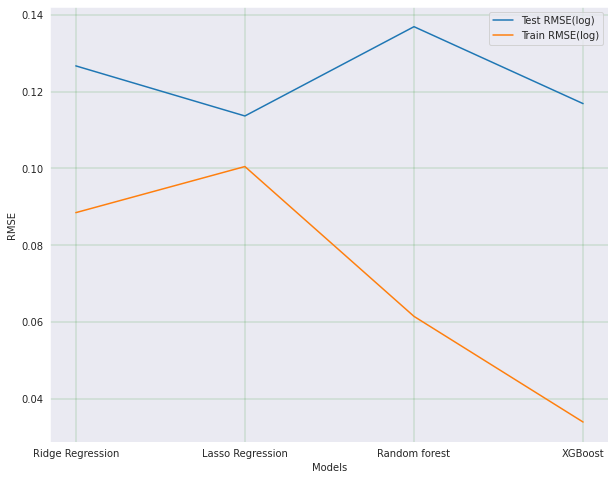

In [ ]:
plt.figure(figsize=(10,8))
plt.plot(df_models_2['Test RMSE(log)'],label='Test RMSE(log)')
plt.plot(df_models_2['Train RMSE(log)'],label='Train RMSE(log)')
plt.legend()
plt.grid(color='green', linestyle='-', linewidth=0.2)
plt.xlabel('Models')
plt.ylabel('RMSE')
plt.show()

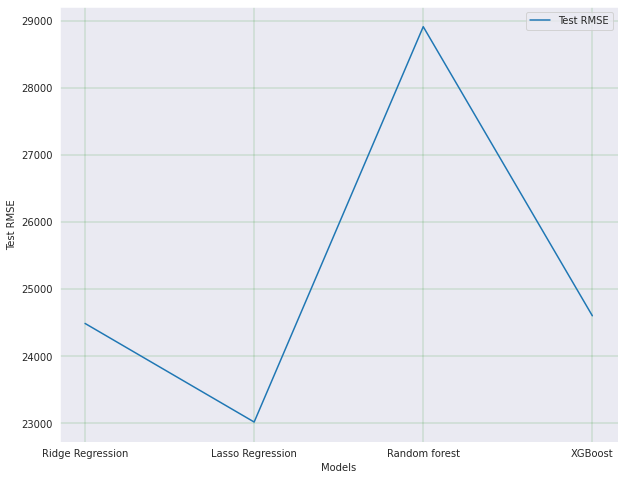

In [ ]:
plt.figure(figsize=(10,8))
plt.plot(df_models['Test RMSE'],label='Test RMSE')

plt.legend()
plt.grid(color='green', linestyle='-', linewidth=0.2)
plt.xlabel('Models')
plt.ylabel('Test RMSE')
plt.show()

**Predict and Export Results**

Lasso

In [ ]:
#train the model on the whole dataset
LA_R.fit(train_final, log_target)
LA_R_pred = np.expm1(LA_R.predict(test_final))
#export the prediction
submission = pd.concat([test_ids, pd.Series(LA_R_pred, name='SalePrice')], axis=1)
submission.to_csv('LA_R.csv', index=False, header=True)
#0.13095 --> 0.12695

In [ ]:
CBG.fit(train_final, log_target)
CBG_pred = np.expm1(CBG.predict(test_final))
#export the prediction
submission = pd.concat([test_ids, pd.Series(CBG_pred, name='SalePrice')], axis=1)
submission.to_csv('CATBOOST.csv', index=False, header=True)
#0.12474 --> 653

In [ ]:
XBG.fit(train_final, log_target)
XBG_pred = np.expm1(XBG.predict(test_final))
#export the prediction
submission = pd.concat([test_ids, pd.Series(XBG_pred, name='SalePrice')], axis=1)
submission.to_csv('XGBOOST.csv', index=False, header=True)
#0.13895

[12:04:51] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [ ]:
#Ensemble different models
Ensemble_pred = (
    0.4 * CBG_pred +
    0.2 * XBG_pred +
    0.4 * LA_R_pred
)
submission = pd.concat([test_ids, pd.Series(Ensemble_pred, name='SalePrice')], axis=1)
submission.to_csv('Ensemble.csv', index=False, header=True)
#0.12324 --> 516